In [0]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [0]:
from google.colab import drive

In [0]:
import torch
def new_data(file):
  ml = 0
  d = {}
  ind2w = {0: "SOS", 1: "EOS"}
  lets = 2
  f  = file
  mass = []
  mspec = []
  smi = []
  nmr = []
  atom = []
  ir = []
  c = 0
  for line in f:
    if line[0].isalpha() == True:
        c += 1
        smi.append(line.strip())
        for letter in line.strip():
          if letter not in d:
            d[letter] = int(lets)
            ind2w[lets] = letter
            lets += 1

        if len(line.strip()) > ml:
          ml = len(line.strip())
        else: 
          ml = ml
        if c > 1:
          mass.append(torch.tensor(mspec).cuda())
        mspec = []
    else:
       if len(line.split()) == 2 and not '[' in line:
        mspec.append((float(line.split()[0]),float(line.split()[1])))


       else:
         nmr.append((line.split("],")[0]).split("[")[1].split(",")[:-6]) 
         atom.append((line.split("],")[0]).split("[")[1].split(",")[-6:-3])
         ir.append((line.split("],")[0]).split("[")[1].split(",")[-3:])
  nmrs = [torch.tensor([float(h) for h in i]).unsqueeze(dim=0).cuda() for i in nmr]  
  atoms = [torch.tensor([float(k) for k in ii]).unsqueeze(dim=0).cuda() for ii in atom]
  irs = [torch.tensor([float(j) for j in iii]).unsqueeze(dim=0).cuda() for iii in ir]
  return mass, nmrs, atoms, irs, smi, ml, d, ind2w



In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
## Modules taken from set-transformer Joho Lee et al.

In [0]:
cd /content/drive/My\ Drive/set_transformer-master

/content/drive/My Drive/set_transformer-master


In [0]:
f = open('../ms-m-ir-nmr.txt')


In [0]:
x,x2,x3,x4,y,ml,dic,ind2w = new_data(f)
#parche temporal por que no lee ultimo spec de mass
del x2[-1]
del x3[-1]
del x4[-1]
del y[-1]

In [0]:
## Modules taken from set-transformer Joho Lee et al. except the Decoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modules import *
import numpy as np


class SmallDeepSet(nn.Module):
    def __init__(self, pool="max"):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_features=1, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
        )
        self.dec = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
        )
        self.pool = pool

    def forward(self, x):
        x = self.enc(x)
        if self.pool == "max":
            x = x.max(dim=1)[0]
        elif self.pool == "mean":
            x = x.mean(dim=1)
        elif self.pool == "sum":
            x = x.sum(dim=1)
        x = self.dec(x)
        return x


class SmallSetTransformer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.enc = nn.Sequential(
            SAB(dim_in=1, dim_out=64, num_heads=4),
            SAB(dim_in=64, dim_out=64, num_heads=4),
        )
        self.dec = nn.Sequential(
            PMA(dim=64, num_heads=4, num_seeds=1),
            nn.Linear(in_features=64, out_features=64),
        )

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze(-1)

class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=64, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))


class DecoderRNN(nn.Module):
        def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_length=ml):
                super(DecoderRNN, self).__init__()
                self.embed = nn.Embedding(vocab_size, embed_size)
                self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
                self.out = nn.Linear(hidden_size, vocab_size)
                self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, in_smiles ,hidden,cell):#
                embeddings = self.embed(in_smiles).view(1,1,-1)
                embeddings = F.relu(embeddings)
                output,(hidden, cell) = self.lstm(embeddings,(hidden,cell))
                outputs = self.softmax(self.out(output[0]))
                return outputs, hidden, cell



In [0]:
EMB=512
HID=512
LAY=4

VOC = len(ind2w)


In [0]:
def tensor_from_smiles(smiles_b):
        indexes = [dic[let] for let in smiles_b]
        indexes.append(int(1)) # 0 : EOS token
        in_smiles = torch.cuda.LongTensor(indexes)
        

        return in_smiles

In [0]:
def evaluate(encoder1, encoder2, encoder3, encoder4, decoder,x,x2,x3,x4,smi):

	loss2 = 0
	hidden1 = encoder1(x)
	temp = torch.randn(LAY,1,int(HID/4)).cuda()
	temp[0] = hidden1
	temp[1] = hidden1
	temp[2] = hidden1
	temp[3] = hidden1
	hidden1 = temp
	hidden2 = encoder2(x2)
	temp2 = torch.randn(LAY,1,int(HID/4)).cuda()
	temp2[0] = hidden2
	temp2[1] = hidden2
	temp2[2] = hidden2
	temp2[3] = hidden2
	hidden2 = temp2
	hidden3 = encoder3(x3)
	temp = torch.randn(LAY,1,int(HID/4)).cuda()
	temp3[0] = hidden3
	temp3[1] = hidden3
	temp3[2] = hidden3
	temp3[3] = hidden3
	hidden3 = temp3
	hidden4 = encoder4(x4)
	temp4 = torch.randn(LAY,1,int(HID/4)).cuda()
	temp4[0] = hidden4
	temp4[1] = hidden4
	temp4[2] = hidden4
	temp4[3] = hidden4
	hidden4 = temp4
 
	hidden = torch.cat((hidden1,hidden2,hidden3,hidden4),dim=-1) #
	cell = hidden
	pretarget = tensor_from_smiles(smi)
	target = torch.cuda.LongTensor([[0]])
	for di in range(len(pretarget)):
		output, hidden, cell = decoder(target,hidden,cell)			
		target = pretarget[di].unsqueeze(dim=0)
		loss2 += criterion(output, target)
	voss = loss2.item()/len(pretarget)
	return  voss

def evaval(encoder1, encoder2,encoder3,encoder4,decoder,val_pairs):
	voss=0
	for i in range(len(val_pairs[0])):
		X = torch.tensor(val_pairs[0][i]).cuda().unsqueeze(dim=0)
		X2 = torch.tensor(val_pairs[1][i]).cuda().unsqueeze(dim=-1)
		X3 = torch.tensor(val_pairs[2][i]).cuda().unsqueeze(dim=-1)
		X4 = torch.tensor(val_pairs[3][i]).cuda().unsqueeze(dim=-1)
		smi = val_pairs[4][i]
		voss += evaluate(encoder1,encoder2,encoder3,encoder4,decoder,X,X2,X3,X4,smi)
	voss_prom = voss/(len(val_pairs[0]))
	return voss_prom
def evaluateR(encoder1, encoder2,encoder3,encoder4,decoder,x,x2,x3,x4,max_length=ml): # puede cambiarse a numero muy grande
         hidden1 = encoder1(x)
         temp = torch.randn(LAY,1,int(HID/4)).cuda()
         temp[0] = hidden1
         temp[1] = hidden1
         temp[2] = hidden1
         temp[3] = hidden1
         hidden1 = temp
         hidden2 = encoder2(x2)
         temp2 = torch.randn(LAY,1,int(HID/4)).cuda()
         temp2[0] = hidden2
         temp2[1] = hidden2
         temp2[2] = hidden2
         temp2[3] = hidden2
         hidden2 = temp2
         hidden3 = encoder3(x3)
         temp3 = torch.randn(LAY,1,int(HID/4)).cuda()
         temp3[0] = hidden3
         temp3[1] = hidden3
         temp3[2] = hidden3
         temp3[3] = hidden3
         hidden3 = temp3
         hidden4 = encoder4(x4)
         temp4 = torch.randn(LAY,1,int(HID/4)).cuda()
         temp4[0] = hidden4
         temp4[1] = hidden4
         temp4[2] = hidden4
         temp4[3] = hidden4
         hidden4 = temp4


         hidden = torch.cat((hidden1,hidden2,hidden3,hidden4),dim=-1)
         cell = hidden
         target =torch.cuda.LongTensor([0])#0: SOS
         decoded_words = []
         for di in range(max_length):
                 output, hidden, cell = decoder(target,hidden,cell)
                 topv,topi = output.data.topk(1)
                 if int(topi[0][0]) == int(1): # EOS 
                         decoded_words.append('<EOS>')
                         break
                 else:
                         decoded_words.append(ind2w[int(topi[0][0])])
                 target = topi.squeeze().unsqueeze(dim=0)
         return decoded_words

def evaluateRandomly(encoder1, encoder2, encoder3,encoder4,decoder,ppair,n=50):
        for i in range(n):
                choice = random.randint(0,len(ppair)-1)
                xt = torch.tensor(ppair[0][choice]).cuda().unsqueeze(dim=0)
                x2t = torch.tensor(ppair[1][choice]).cuda().unsqueeze(dim=-1)
                x3t = torch.tensor(ppair[2][choice]).cuda().unsqueeze(dim=-1)
                x4t = torch.tensor(ppair[3][choice]).cuda().unsqueeze(dim=-1)

                smi = ppair[4][choice]
		
                output_words = evaluateR(encoder1,encoder2,encoder3,encoder4,decoder,xt,x2t,x3t,x4t)
                output_s = ''.join(output_words)
                print("pred:",output_s)
                print("real:",smi)
def evaluateTodo(encoder1,encoder2,encoder3,encoder4,decoder,ppair):
        for i in range(len(ppair[0])):
                X = torch.tensor(ppair[0][i]).cuda().unsqueeze(dim=0)
                X2 = torch.tensor(ppair[1][i]).cuda().unsqueeze(dim=-1)
                X3 = torch.tensor(ppair[2][i]).cuda().unsqueeze(dim=-1)
                X4 = torch.tensor(ppair[3][i]).cuda().unsqueeze(dim=-1)

                smi = ppair[4][i]
                output_words = evaluateR(encoder1,encoder2,encoder3,encoder4,decoder,X,X2,X3,X4)
                output_s = ''.join(output_words)
                print("pred:",output_s)
                print("real:",smi)

In [0]:
criterion = torch.nn.NLLLoss()

validation set evaluation, epoch: 1
pred: CCCCCCCO<EOS>
real: COCC)C)OC
pred: CCCCCCOOO<EOS>
real: CCC=O)OC=O)CC
pred: CCCCCCCO<EOS>
real: CCC)CC=O
pred: CCCccccccc66<EOS>
real: CCCC=O)))cccccc6
pred: CCCCCOOO<EOS>
real: C=CC)C=O)O
pred: CCCCCCCCCCC<EOS>
real: C=CCCCCC5)C6C)C


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

pred: CCccccccc)))66<EOS>
real: CcccC)cC=O))cC)c6
pred: CCCCCOOOO<EOS>
real: C=CC=O)OCCO
pred: CCCCCCCCCOOOOO<EOS>
real: CCOC=O)C=CC=O)OCC
pred: CCCCCCCOOO<EOS>
real: O=COCCCCCC6
pred: CCCCCCCC<EOS>
real: CCCCCCO
pred: CCCCCcccccOOO<EOS>
real: CCOC=O)Ccccccc6
pred: OCccccccc<EOS>
real: Occcccc6
pred: CCCccccccc6<EOS>
real: OCCOcccccc6
pred: OOcccccccOO)))))6<EOS>
real: O=CO)cccO)cO)cO)c6
pred: CCCCCCCCC))O<EOS>
real: O=CO)CCCCCCC6C5
pred: COCccccccOOO))<EOS>
real: CC=O)cccO)ccc6O
pred: Cccccccccc)66<EOS>
real: CC=Ccccccc6)OCO5
pred: CCCCOO<EOS>
real: COCCO
pred: CCCCCCCCCC)))<EOS>
real: CCCCCC5)CC)C)C6O
pred: OOccccccccc6<EOS>
real: Occccccccc6c%10
pred: CCCCCCCccc)6<EOS>
real: CccccCC)C)O))cc6
pred: COccccccc)))))))6<EOS>
real: C=CCccccO)cOC))c6
pred: CCCCCCCCC<EOS>
real: CCOCC)OCC
pred: CCCCCCCOOO<EOS>
real: CCCC)C=O)OC
pred: OOcccccccOOOOO))ccc<EOS>
real: O=CO)C=CC=O)O
pred: CCCCCCCCC)<EOS>
real: CCCCCCCCO
pred: CCCccccccc6<EOS>
real: CCO)cccccc6
pred: OCCCCOOOO<EOS>
real: O=CC=CC=O

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

val 1 1720 1.172548989032036


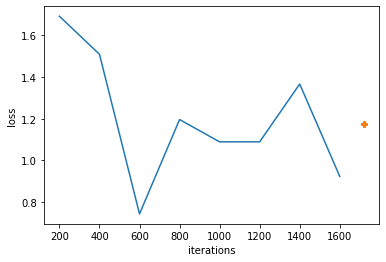

train set eval
epoch:  1
pred: CCCCCCCCC)<EOS>
real: CCCCCCC6O
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCC))<EOS>
real: CCCCCCC6O
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCO<EOS>
real: CCOC4
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCCCCC))<EOS>
real: CCCCCCC6O


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCC)<EOS>
real: CCCCCCC6O
pred: CCCCCCCC))<EOS>
real: CCCCCCC6O
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCC)<EOS>
real: CCCCCCC6O
pred: CCCCO<EOS>
real: CCOC4
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCO<EOS>
real: CCOC4
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCO<EOS>
real: CCOC4
pred: OOCccccccc66<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCCC))<EOS>
real: CCCCCCC6O
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCO<EOS>
real: CCCCCC5=O
pred: OOCcccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: OOCCccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCO<EOS>
real: CCOC4
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCCOOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCC<EOS>


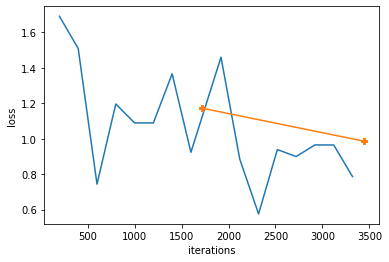

train set eval
epoch:  2
pred: CCCCCC==OCCCOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCCO<EOS>
real: CCCCCCC6O
pred: OOCCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC==O)CCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC==OOCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC==O<EOS>
real: CCCCCC5=O
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCOO<EOS>
real: CCOC4
pred: CCCCCC==O<EOS>
real: CCCCCC5=O
pred: CCCCCCCCOO<EOS>
real: CCCCCCC6O
pred: CCCCCCC==OOCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC==O<EOS>
real: CCCCCC5=O
pred: CCCCCCCCO<EOS>
real: CCCCCCC6O
pred: CCCCCC==O<EOS>
real: CCCCCC5=O
pred: CCCCCC==OCCOOO<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCOO<EOS>
real: CCOC4
pred: CCCOO<EOS>
real: CCOC4
pred: CCCCCCCCO<EOS>
real: CCCCCCC6O
pred: CCCOO<EOS>
real: CCOC4
pred: OOCCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: OOCCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCOO<EOS>
real: CCOC4
pred: OOCCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC==OCCCOO<EOS>
real: C=CC)CCC=

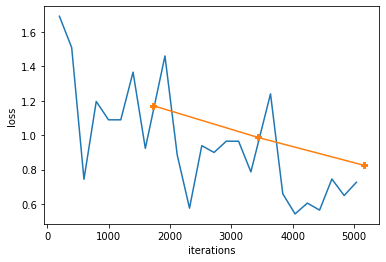

train set eval
epoch:  3
pred: CCC=CCC=O)CCC=<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC==)O<EOS>
real: CCCCCC5=O
pred: CCCC=CC=O)CCC=<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCCC6<EOS>
real: CCCCCCC6O
pred: CCCO<EOS>
real: CCOC4
pred: CCCC=OCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCO<EOS>
real: CCOC4
pred: O=CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCO<EOS>
real: CCOC4
pred: CCCO<EOS>
real: CCOC4
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC==)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC==))C<EOS>
real: CCCCCC5=O
pred: CCCC=CCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCO<EOS>
real: CCOC4
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCO<EOS>
real: CCOC4
pred: CCCCC==)O<EOS>
real: CCCCCC5=O
pred: O=CCO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred

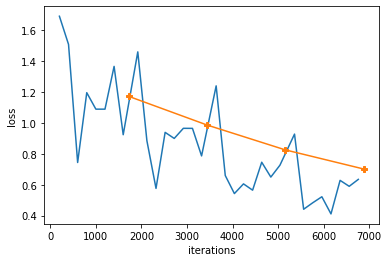

train set eval
epoch:  4
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CC=)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CC=)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCO<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCO<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6<EOS>
real: CCCCCCC6O
pred: CCCCCCC6<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CC=)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6<EOS>
real: CCCCCCC6O
pred: O=CC=)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=)OC<EOS>
real

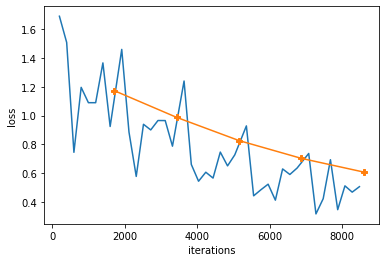

train set eval
epoch:  5
pred: CCOO<EOS>
real: CCOC4
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOO<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOO<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCOO<EOS>
real: CCOC4
pred: CC=CCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCC=O)CCCC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CC=CCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCC=O)CCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pre

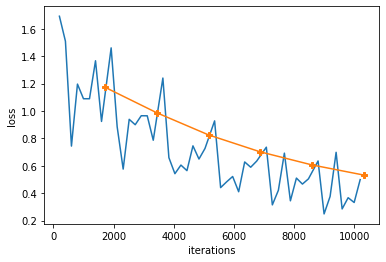

train set eval
epoch:  6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOO<EOS>
real: CCOC4
pred: O=CO)cccccc6CO<EOS>
real: O=CO)CO)cccccc6
pred: CCCO<EOS>
real: CCOC4
pred: CCOO<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOO<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOO<EOS>
real: CCOC4
pred: CC=O)CCC)C<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CCCCC)=O<EOS>
real: CCCCCC5=O
pred: CC=O)CCC)C<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCOO<EOS>
real: CCOC4
pred: O=CO)cccccc6CO<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: O=CO)cccccc6CO<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCC=O)CCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6CO<EOS>
real: O=CO)CO)cccccc6
pre

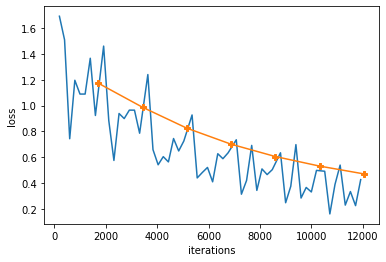

train set eval
epoch:  7
pred: CCCCC=O)O5<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCOC<EOS>
real: CCOC4
pred: CCOC<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCC=O)CCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: CCOC<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCOO<EOS>
real: CCOC4
pred: CCCCC=O)O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: COCO<EOS>
real: CCOC4
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCC=O)CC=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOO<EOS>
real: CCOC4
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred:

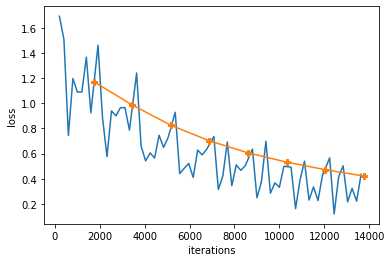

train set eval
epoch:  8
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: COC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC=O)CCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC=O)CCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7


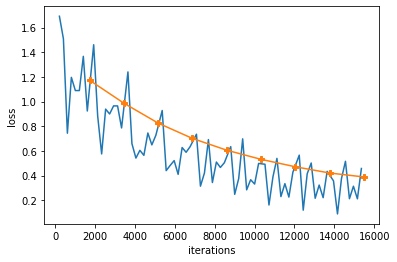

train set eval
epoch:  9
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC<EOS>
real: CCOC4
pred: CCOC=O)CCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: CCCCC=O)C=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: CCOC=O)CCCC)=O)C<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCC=O)CC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCC)=O)CC<EOS>
real: C=CC)CC

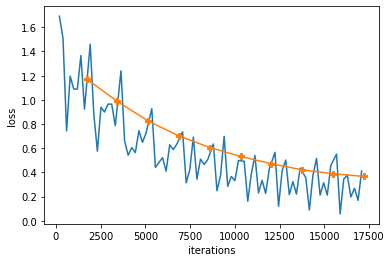

train set eval
epoch:  10
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC<EOS>
real: CCOC4
pred: CCOC<EOS>
real: CCOC4
pred: CCCC=O)C=O)CCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: CCOC<EOS>
real: CCOC4
pred: CCCC=O)C=O)CCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCC=O)C=O)CCC)=OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCC=O)C=O)CCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: CCOC<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6OC<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCC

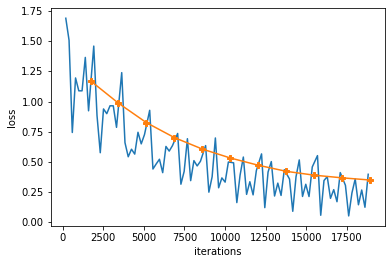

train set eval
epoch:  11
pred: CCOC<EOS>
real: CCOC4
pred: CCCCCCC=O)OC)=C<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6OC<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: CCOC=O)CCCC)=O)C<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O)C5<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCC=O)C6<EOS>
real: CCCCCC5=O
pred: CCOC<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6OC<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)C=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O)C6<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCC)=O)C<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)C=Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pr

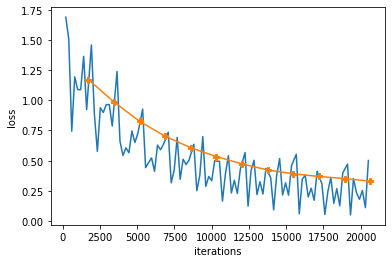

train set eval
epoch:  12
pred: CCCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6C<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6OC<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC

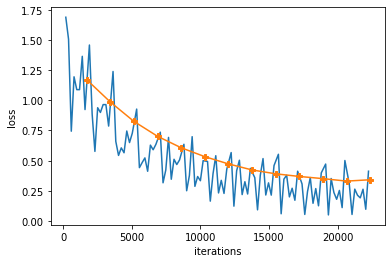

train set eval
epoch:  13
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: COC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: COC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCO)CO<EOS>
real: CCOC4
pred: CCCCCCC

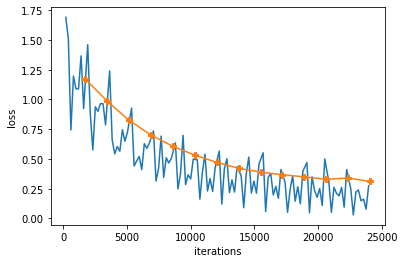

train set eval
epoch:  14
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC=O)CCCC)=OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC=O)CCCC)=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCC)=OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCC)=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3

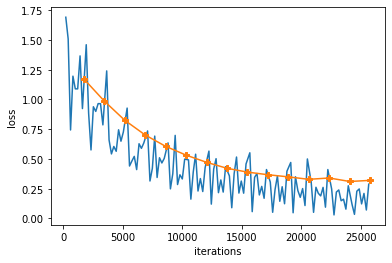

train set eval
epoch:  15
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC=O)CCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7

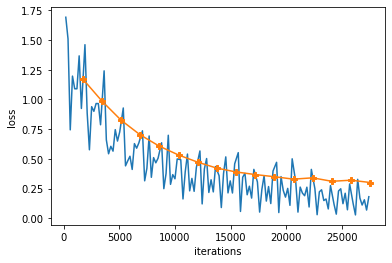

train set eval
epoch:  16
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC=O)CCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pred: O=CCCCCC<EOS>
real: CCCCCC5=O
pre

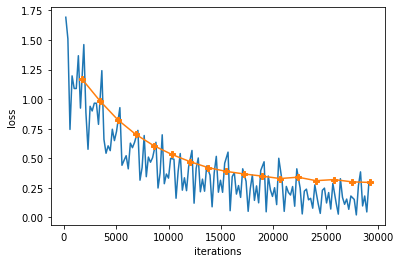

train set eval
epoch:  17
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CC=O)OCCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=O)OCCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CC=CCCC=O)CC)OC6<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CC=CCCC=O)CC)=CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=O)CCCCC=O)CC6<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>

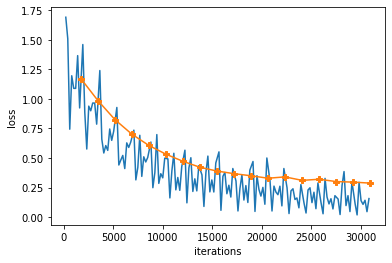

train set eval
epoch:  18
pred: CCOC=O)CCCC)=O))CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC=O)CCCCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCOC=O)CCCCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC=O)CCCCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=O)OCCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC=O)CCCCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: COC=O)CCCCCC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=

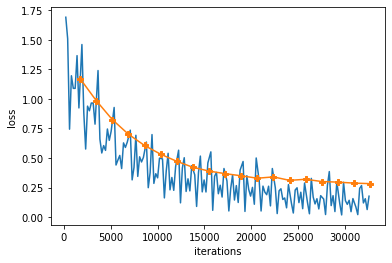

train set eval
epoch:  19
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: CC=O)OCCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CC=CCCC=O)OCC)<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CC=O)OCCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CC=CCCC=O)OCC)=O)CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCO4C<EOS>
real: CCOC4
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CC=O)OCCCCC=

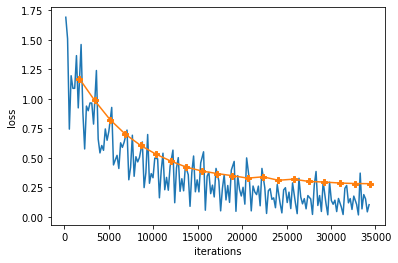

train set eval
epoch:  20
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: COC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCO)C6<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CCCCCC6<EOS>
real: CCCCCC5=O
pred: COC=O)CCCCCC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)Ccccccc6

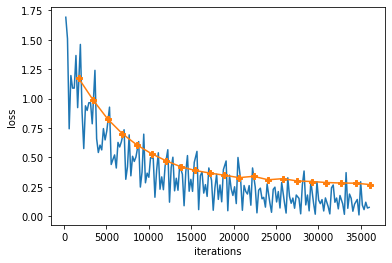

train set eval
epoch:  21
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CC=O)OCCCCCC6OC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=CC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=O)CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CC=O)OCCCCCC6O)C=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CC=CCCC=O)CC)OC6<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=COCcccc

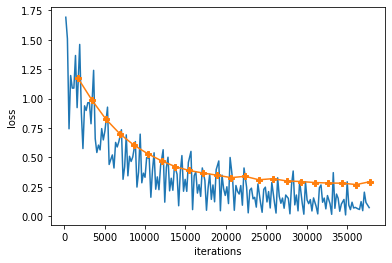

train set eval
epoch:  22
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CC=CCCCC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O

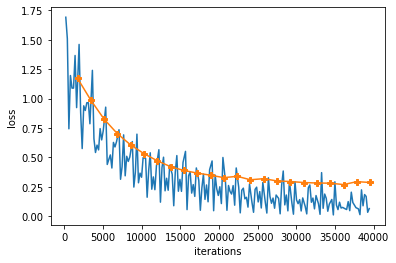

train set eval
epoch:  23
pred: CC=CCCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCO4C<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CC=CCCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CC=CCCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CC=CCCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
r

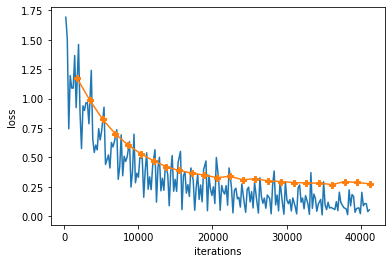

train set eval
epoch:  24
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCC=O<EOS>
real: CCCCCC5=O
p

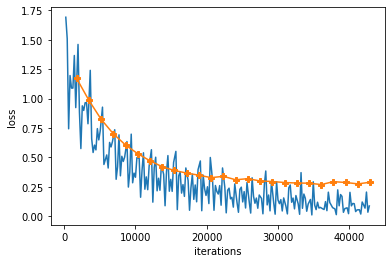

train set eval
epoch:  25
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC=O)C5<EOS>
real: CCCCCC5=O
pred: CCO4C<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCO4C<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCO4C<EOS>
real: CCOC4
pred: CCCCCCC6

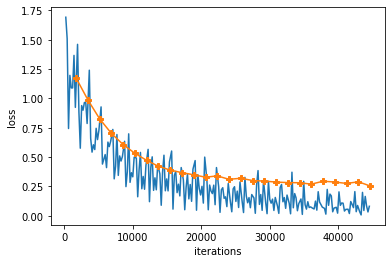

train set eval
epoch:  26
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OC)))C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OC)))C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OC)))C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)OC)))C=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OC)))C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OC)))OC<EOS>

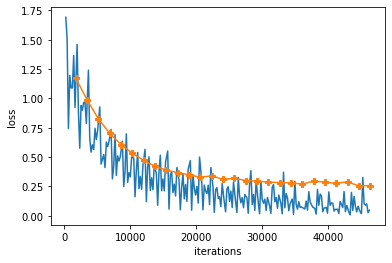

train set eval
epoch:  27
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)C=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=

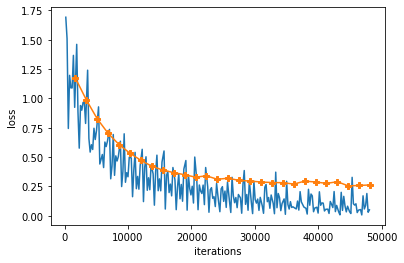

train set eval
epoch:  28
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CC=O)CCC)=CC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CC=O)CCC)=OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
rea

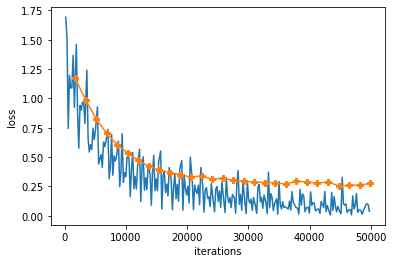

train set eval
epoch:  29
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC=O)C=O)O5<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC=O)C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC=O)C=O)O5<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real

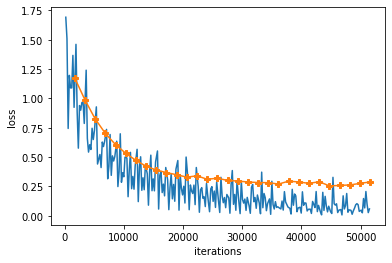

train set eval
epoch:  30
pred: CCCCC=O)C5<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)OC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC=O)OC)O5<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)OC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)OC))C5O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCC=O)C5<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred

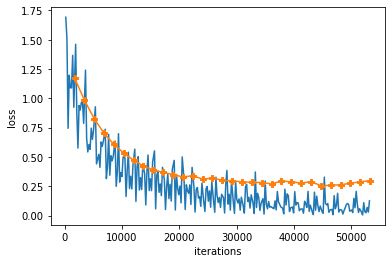

train set eval
epoch:  31
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC5C5<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=Ccccccc6CO<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=CC=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCC5C5O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCC5C5O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6

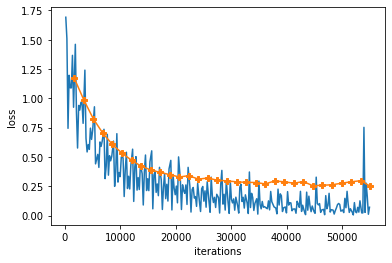

train set eval
epoch:  32
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pre

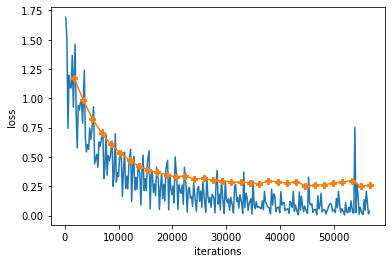

train set eval
epoch:  33
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCO4C<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC=O)C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCO4C<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC=O)C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<

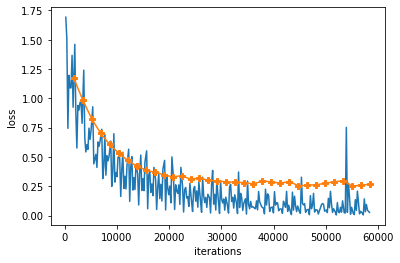

train set eval
epoch:  34
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real

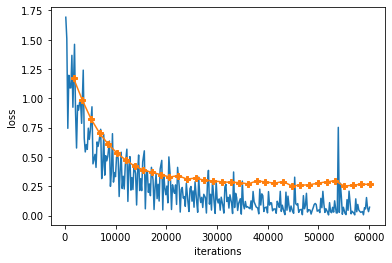

train set eval
epoch:  35
pred: CCCCCCC=O)OC)O5<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OC)))OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EO

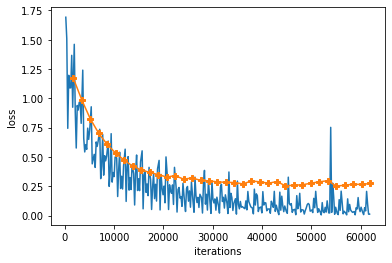

train set eval
epoch:  36
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC=O)C=O)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCO)C4O<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCO4C<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)C

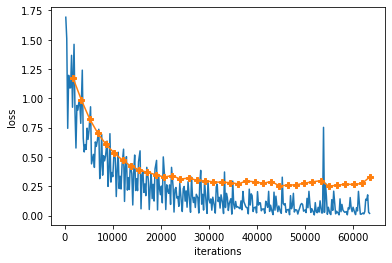

train set eval
epoch:  37
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CCOCCCCC=O)CC6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<E

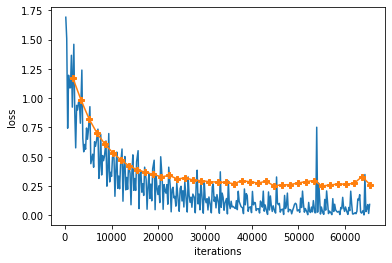

train set eval
epoch:  38
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCO4C4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCO4C4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
p

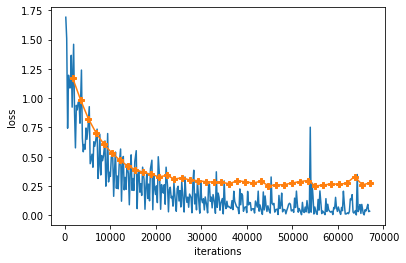

train set eval
epoch:  39
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCO

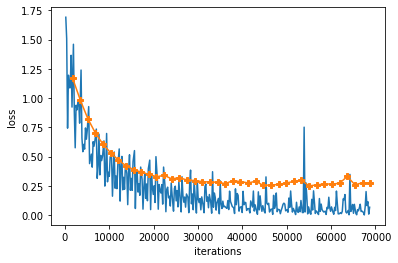

train set eval
epoch:  40
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O

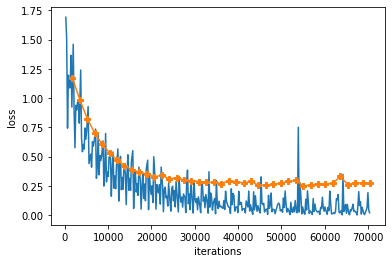

train set eval
epoch:  41
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
re

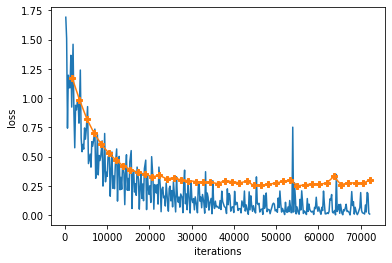

train set eval
epoch:  42
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)

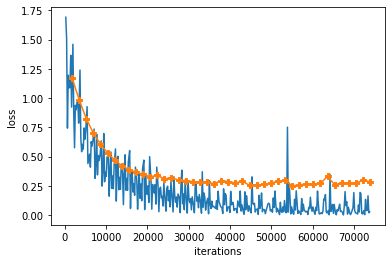

train set eval
epoch:  43
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CCOCCCCC)=OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccc

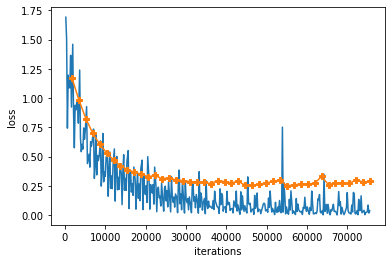

train set eval
epoch:  44
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<

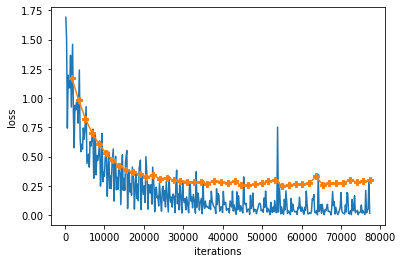

train set eval
epoch:  45
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O

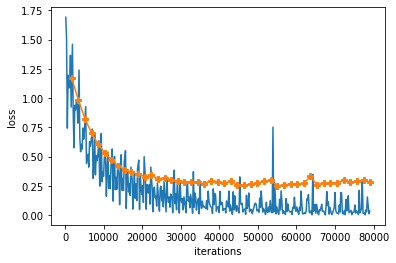

train set eval
epoch:  46
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6

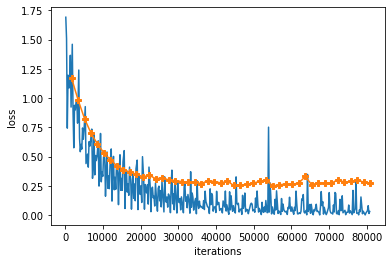

train set eval
epoch:  47
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC=O)OC)))C5O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC=O)OC)))C5O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real

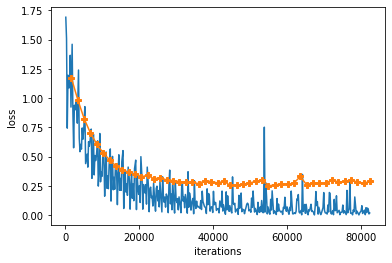

train set eval
epoch:  48
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O

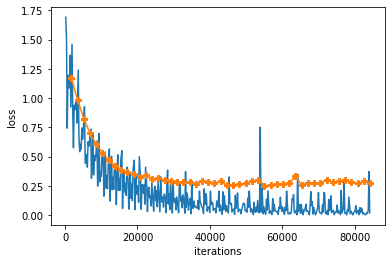

train set eval
epoch:  49
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pr

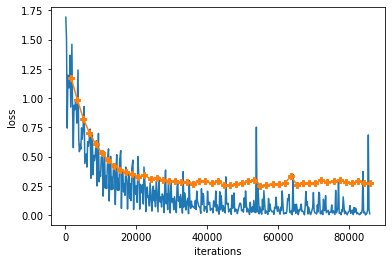

train set eval
epoch:  50
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)O

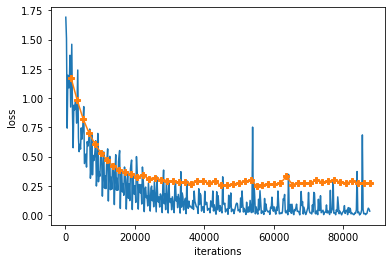

train set eval
epoch:  51
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O


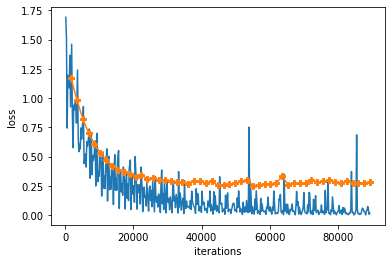

train set eval
epoch:  52
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7


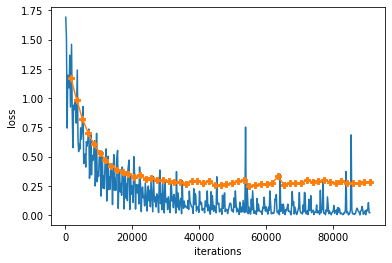

train set eval
epoch:  53
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC

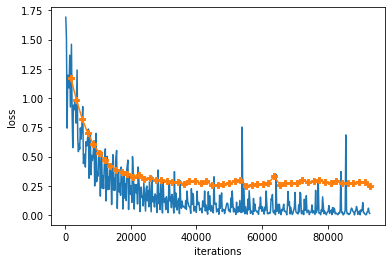

train set eval
epoch:  54
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred:

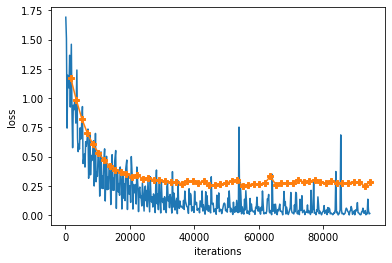

train set eval
epoch:  55
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CCOCCCCC6OC=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)

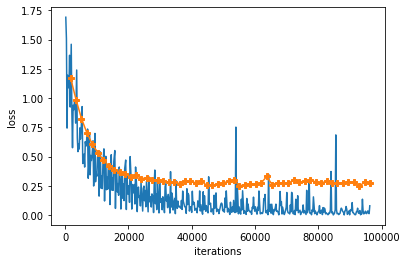

train set eval
epoch:  56
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: C

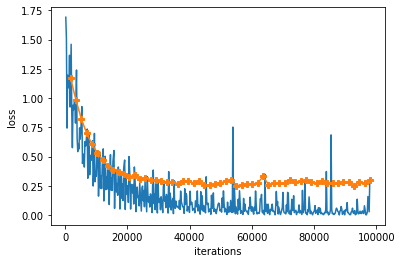

train set eval
epoch:  57
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)Ccccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
rea

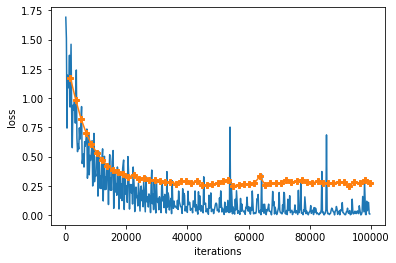

train set eval
epoch:  58
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)ccccc

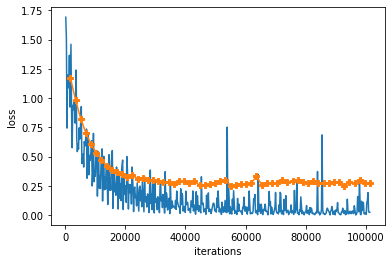

train set eval
epoch:  59
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<

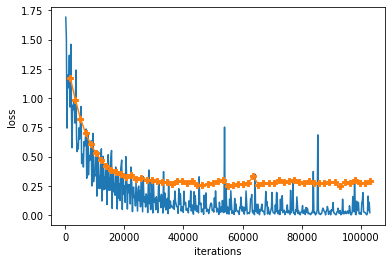

train set eval
epoch:  60
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CC

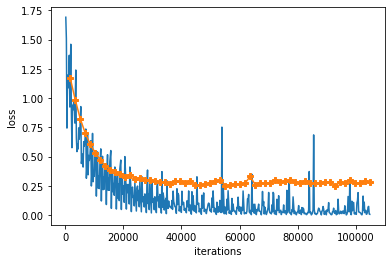

train set eval
epoch:  61
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CCOCCCCCC6=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>

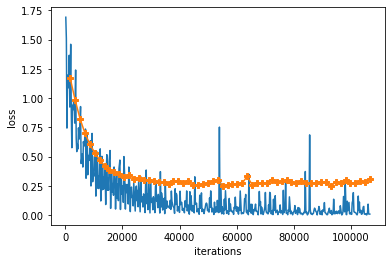

train set eval
epoch:  62
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCO

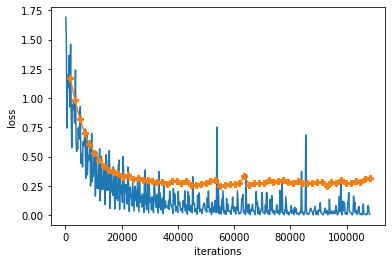

train set eval
epoch:  63
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real:

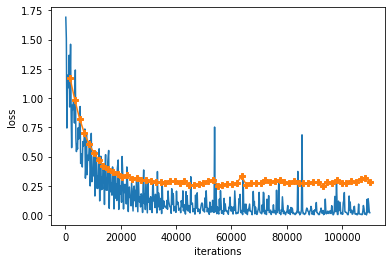

train set eval
epoch:  64
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)

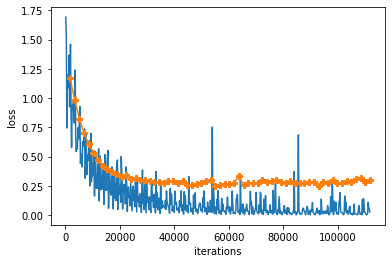

train set eval
epoch:  65
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OC=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=

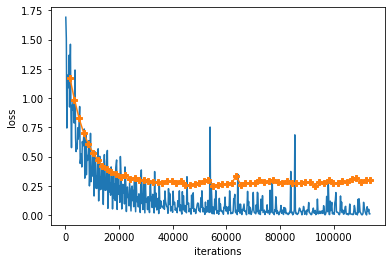

train set eval
epoch:  66
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CC

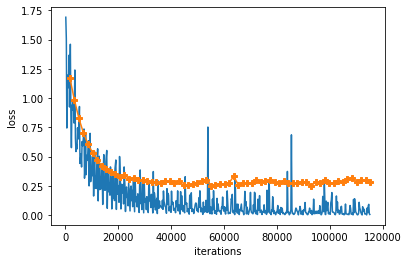

train set eval
epoch:  67
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O

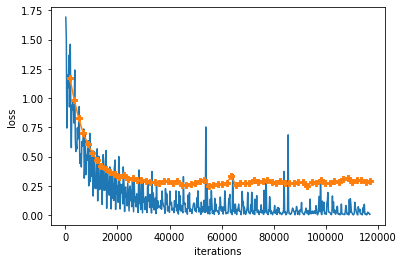

train set eval
epoch:  68
pred: CCCCCOC=O)C=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCC)C=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCOC=O)C=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCOC=O)C=O)OCC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)

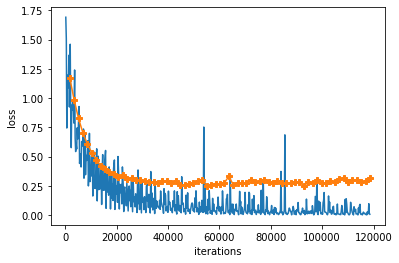

train set eval
epoch:  69
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)cccccc6OC<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
r

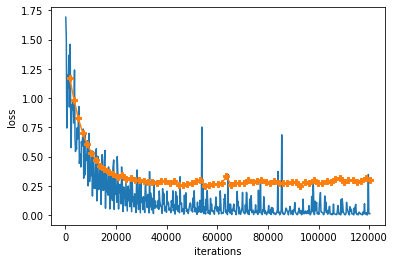

train set eval
epoch:  70
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCC=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real:

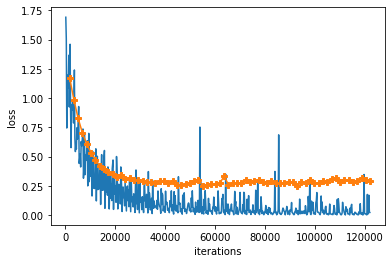

train set eval
epoch:  71
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred

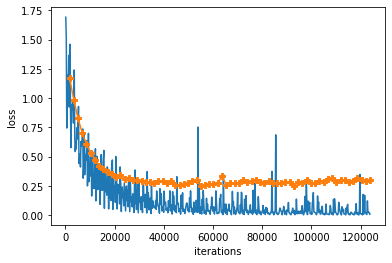

train set eval
epoch:  72
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O

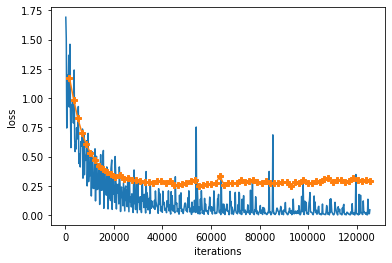

train set eval
epoch:  73
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOO<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>


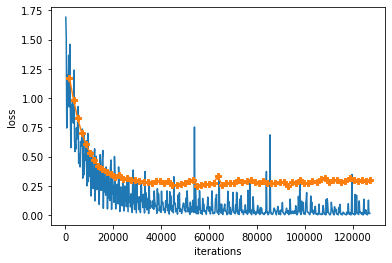

train set eval
epoch:  74
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)C=Ccccccc69<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
re

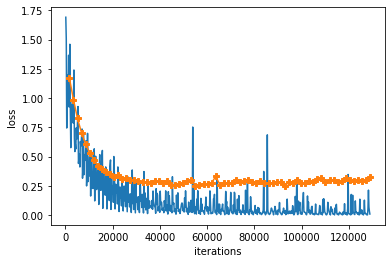

train set eval
epoch:  75
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pr

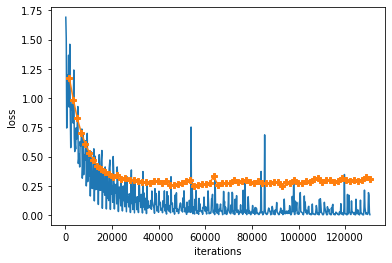

train set eval
epoch:  76
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: C

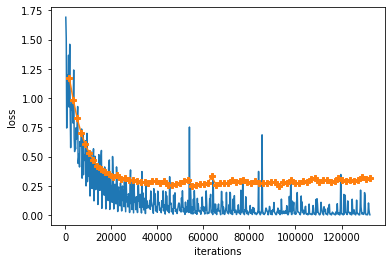

train set eval
epoch:  77
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=COCcccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real:

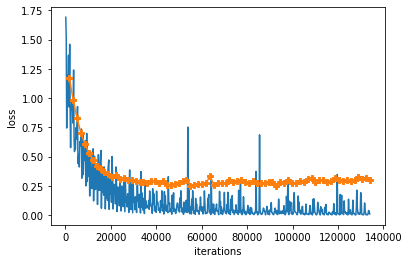

train set eval
epoch:  78
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7

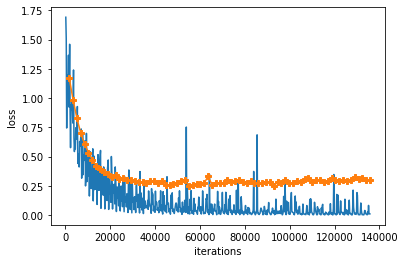

train set eval
epoch:  79
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS

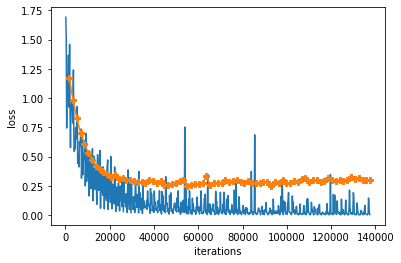

train set eval
epoch:  80
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7


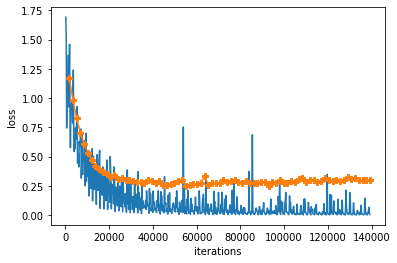

train set eval
epoch:  81
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>

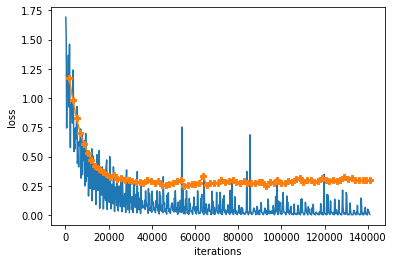

train set eval
epoch:  82
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: 

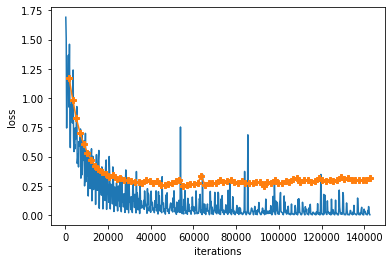

train set eval
epoch:  83
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: C

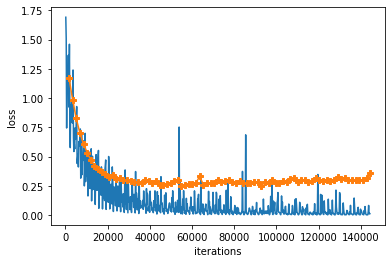

train set eval
epoch:  84
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)Ccccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC=O)OCC)=O)))C5C)O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pr

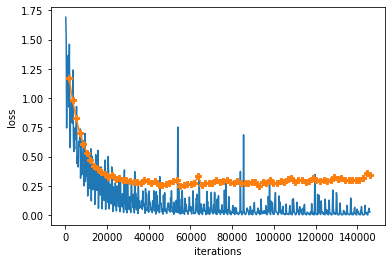

train set eval
epoch:  85
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real

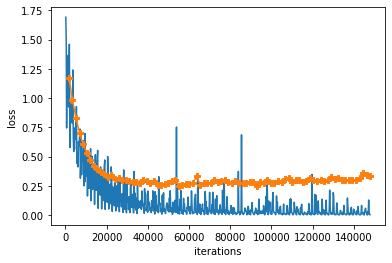

train set eval
epoch:  86
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CC

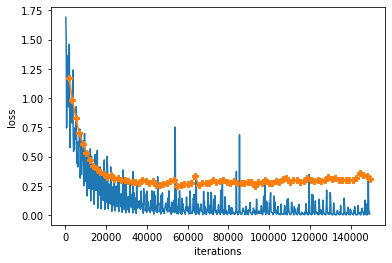

train set eval
epoch:  87
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<

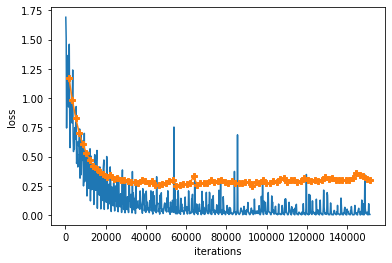

train set eval
epoch:  88
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OC=O))CC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC=O)OC)C=O)OC<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC=O)OC=O))CC5<EOS>
real: C=CC)CCC=O)CC)OC

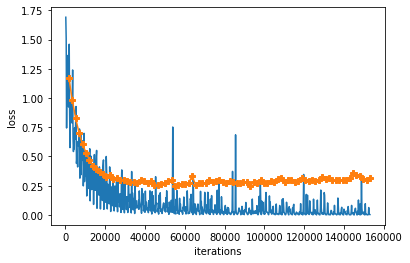

train set eval
epoch:  89
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: 

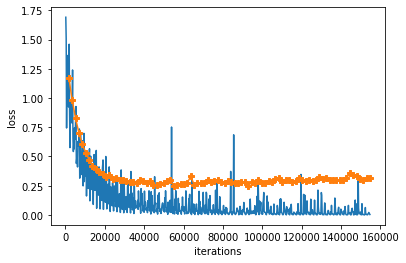

train set eval
epoch:  90
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CC

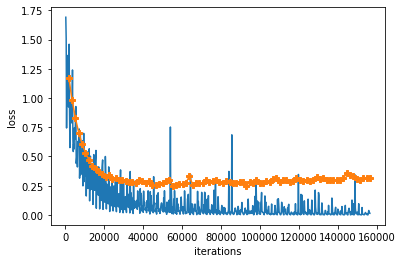

train set eval
epoch:  91
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO

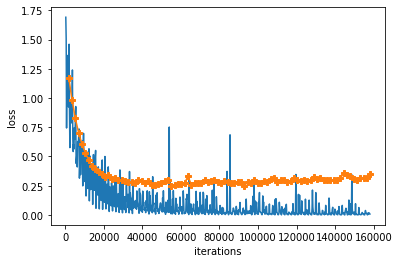

train set eval
epoch:  92
pred: O=CO)CO)cccccc69<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc69<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc69<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O

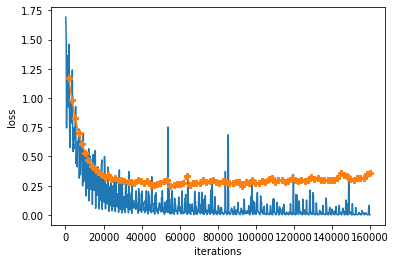

train set eval
epoch:  93
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC=O)OC)O)C5<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6

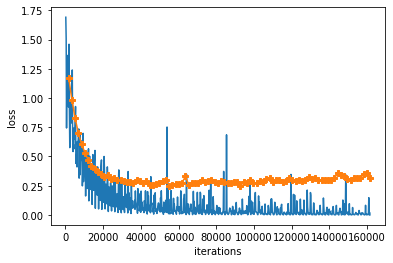

train set eval
epoch:  94
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EO

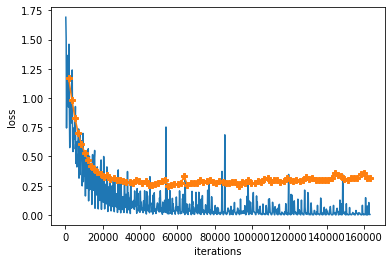

train set eval
epoch:  95
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=C

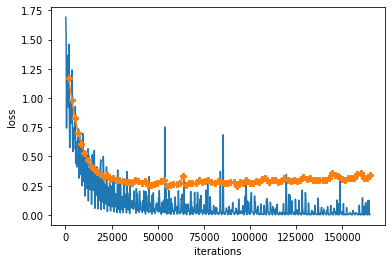

train set eval
epoch:  96
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred:

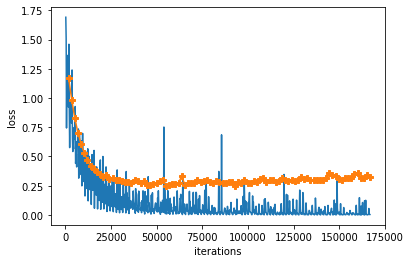

train set eval
epoch:  97
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O

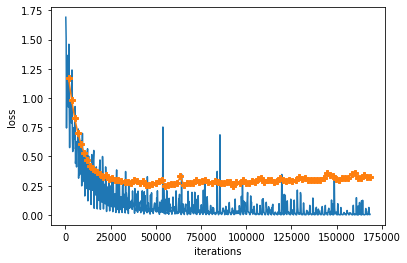

train set eval
epoch:  98
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CCO)C6O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
r

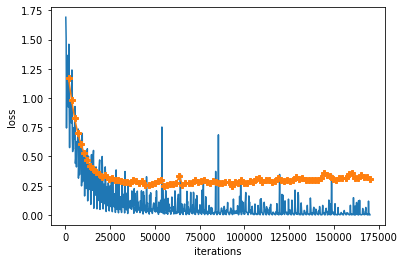

train set eval
epoch:  99
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccc

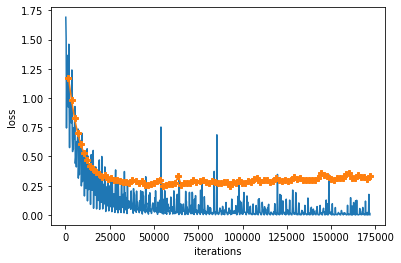

train set eval
epoch:  100
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=C

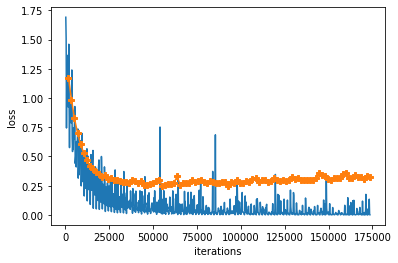

train set eval
epoch:  101
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCC

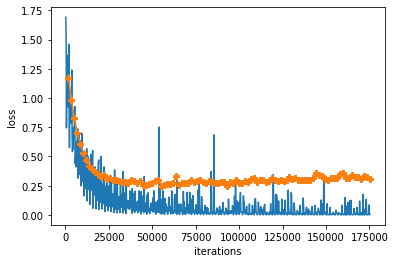

train set eval
epoch:  102
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>


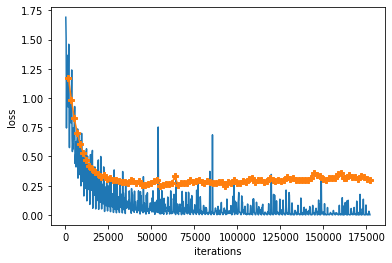

train set eval
epoch:  103
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred

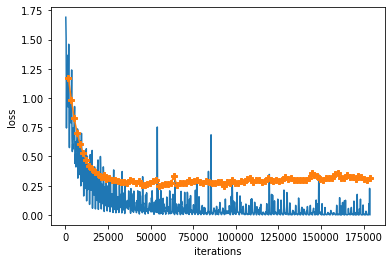

train set eval
epoch:  104
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=

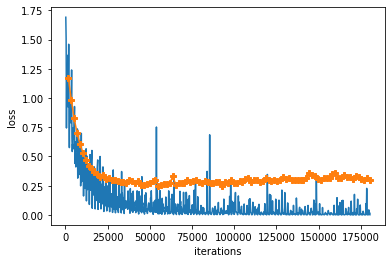

train set eval
epoch:  105
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC

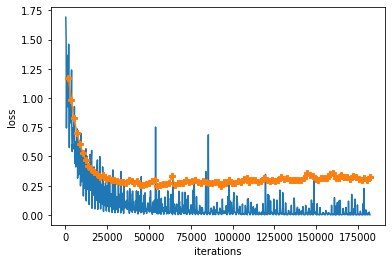

train set eval
epoch:  106
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pr

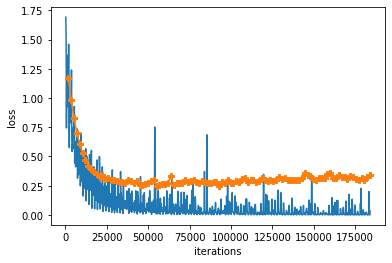

train set eval
epoch:  107
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)C=Ccccccc69<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)C=Ccccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cc

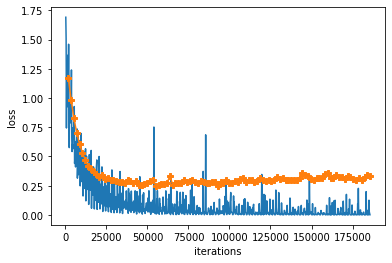

train set eval
epoch:  108
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: 

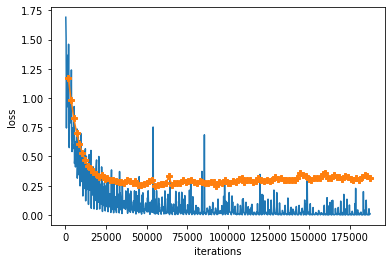

train set eval
epoch:  109
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
re

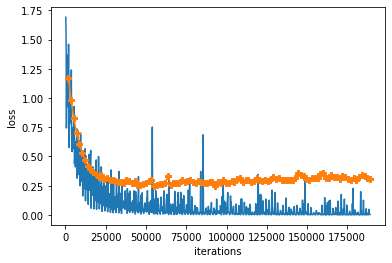

train set eval
epoch:  110
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCC=O)CC5<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pr

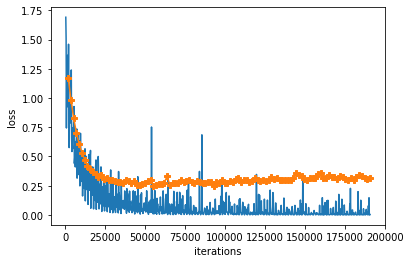

train set eval
epoch:  111
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O


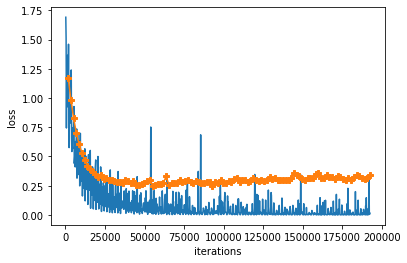

train set eval
epoch:  112
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CC

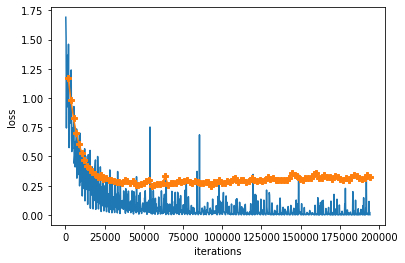

train set eval
epoch:  113
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)O

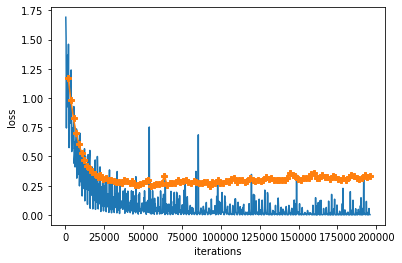

train set eval
epoch:  114
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC

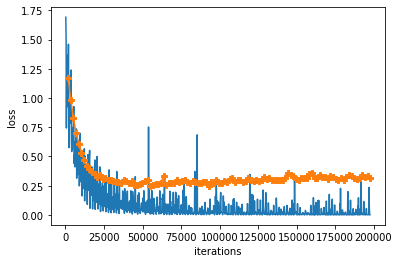

train set eval
epoch:  115
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O

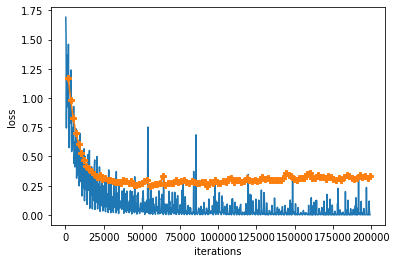

train set eval
epoch:  116
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O

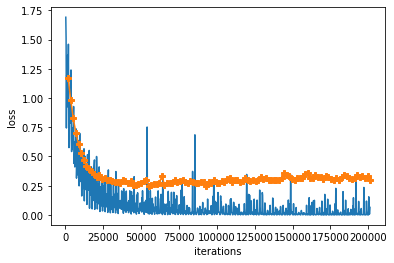

train set eval
epoch:  117
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
re

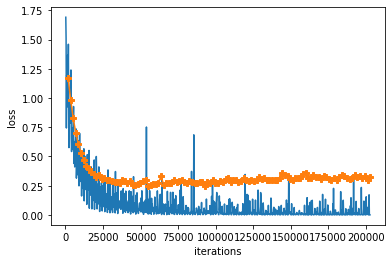

train set eval
epoch:  118
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EO

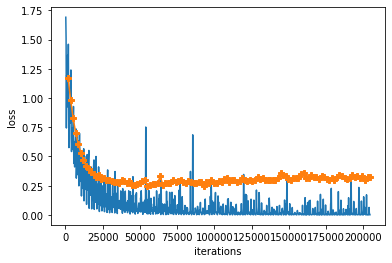

train set eval
epoch:  119
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS

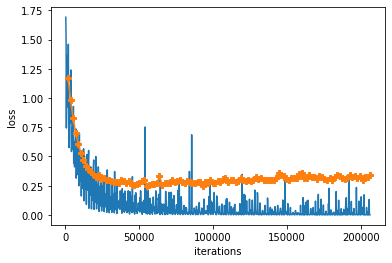

train set eval
epoch:  120
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
r

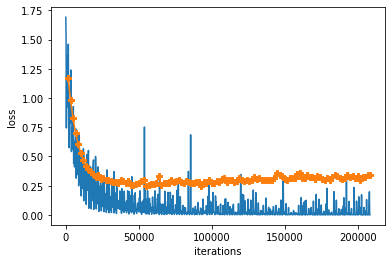

train set eval
epoch:  121
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EO

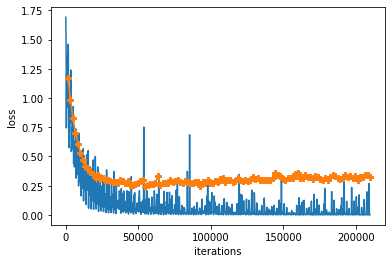

train set eval
epoch:  122
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7

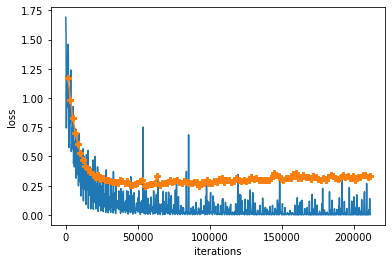

train set eval
epoch:  123
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CC

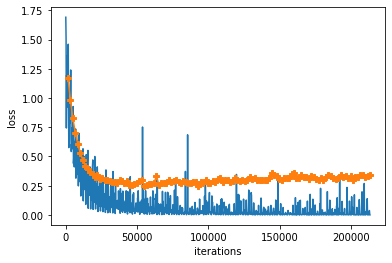

train set eval
epoch:  124
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS

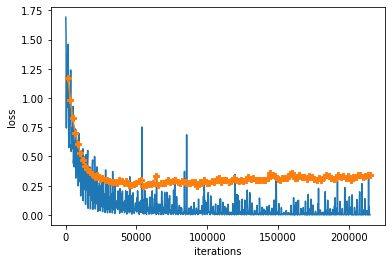

train set eval
epoch:  125
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=C

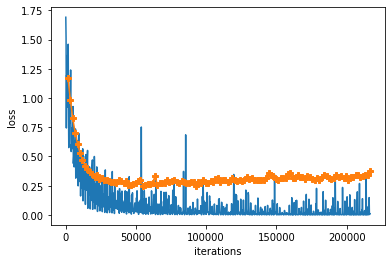

train set eval
epoch:  126
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)ccccc

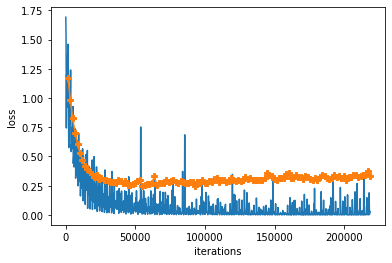

train set eval
epoch:  127
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<

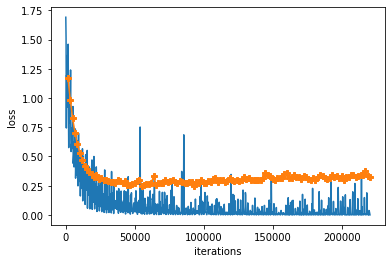

train set eval
epoch:  128
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6

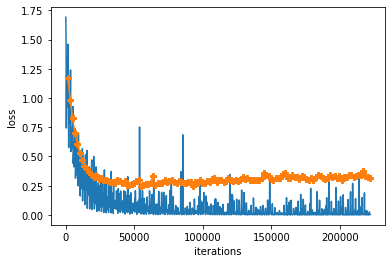

train set eval
epoch:  129
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC

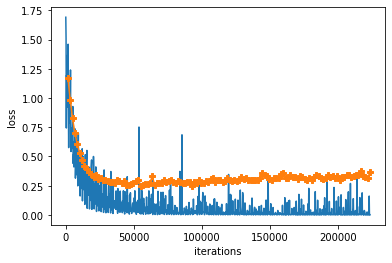

train set eval
epoch:  130
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)ccc

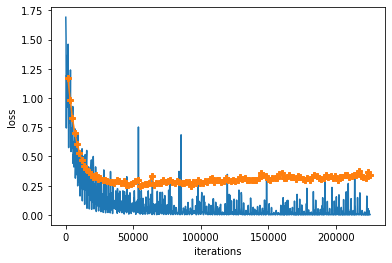

train set eval
epoch:  131
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: C

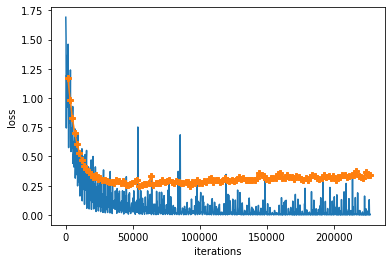

train set eval
epoch:  132
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)

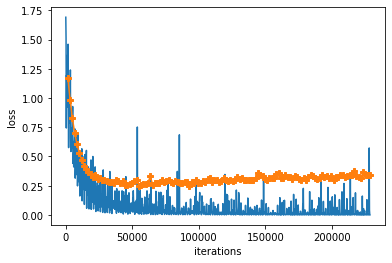

train set eval
epoch:  133
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC

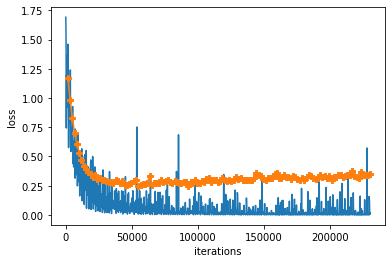

train set eval
epoch:  134
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<E

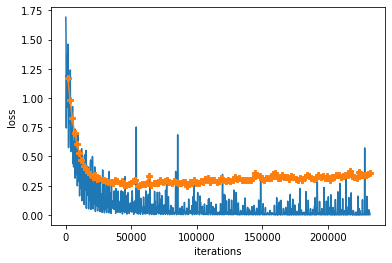

train set eval
epoch:  135
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)C=Ccccccc6O<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O


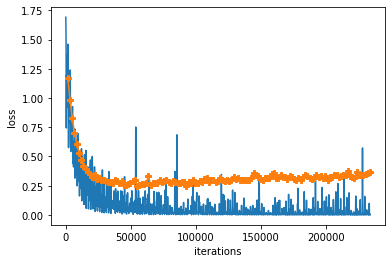

train set eval
epoch:  136
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O


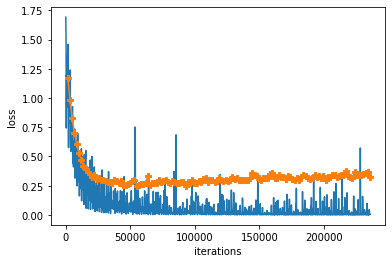

train set eval
epoch:  137
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC

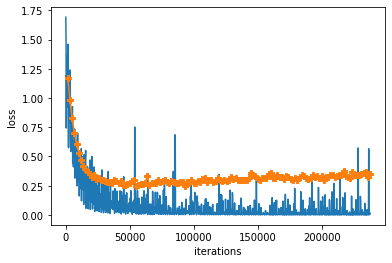

train set eval
epoch:  138
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
re

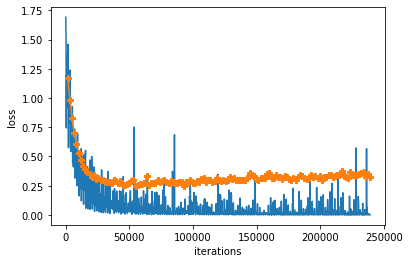

train set eval
epoch:  139
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CC

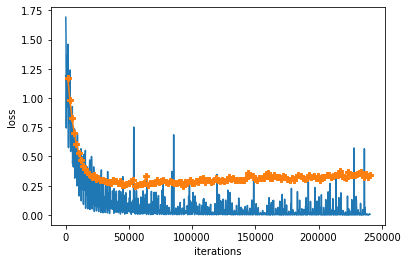

train set eval
epoch:  140
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real:

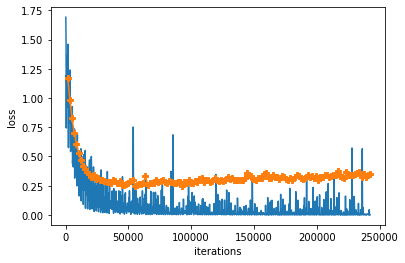

train set eval
epoch:  141
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)C

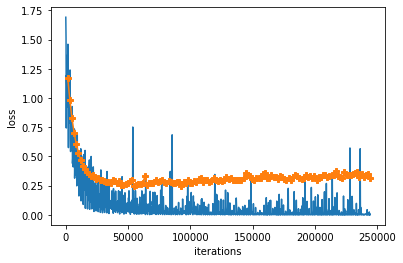

train set eval
epoch:  142
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<E

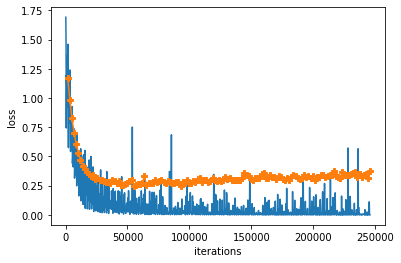

train set eval
epoch:  143
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pr

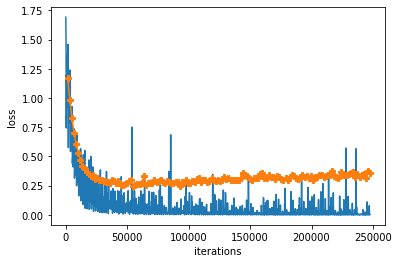

train set eval
epoch:  144
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: 

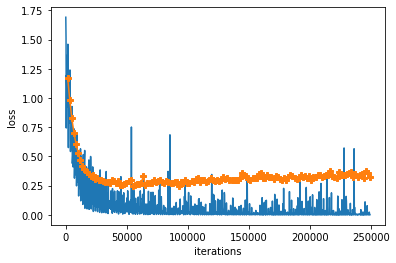

train set eval
epoch:  145
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCC

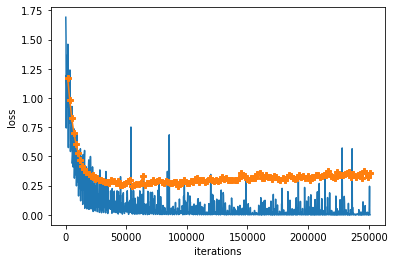

train set eval
epoch:  146
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCC

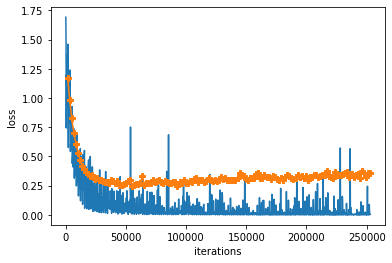

train set eval
epoch:  147
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EO

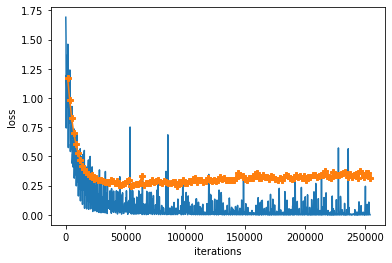

train set eval
epoch:  148
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCO

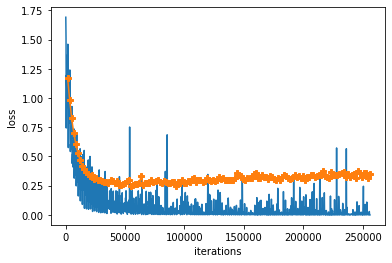

train set eval
epoch:  149
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccc

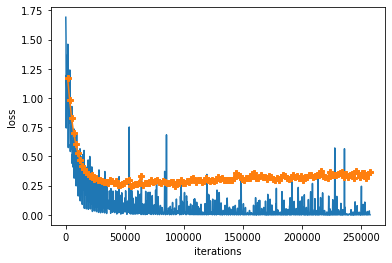

train set eval
epoch:  150
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pr

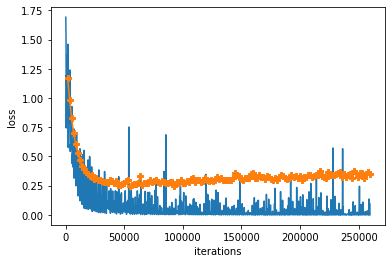

train set eval
epoch:  151
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred:

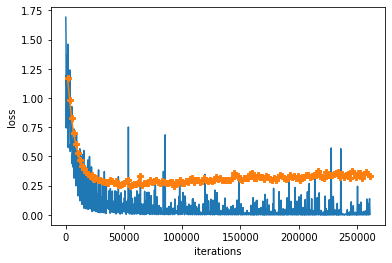

train set eval
epoch:  152
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)C

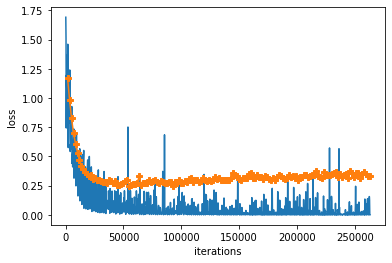

train set eval
epoch:  153
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred

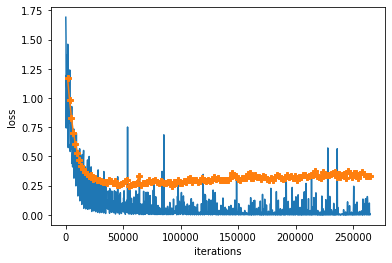

train set eval
epoch:  154
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real:

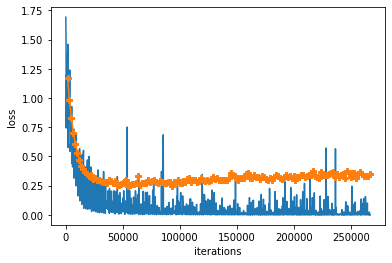

train set eval
epoch:  155
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC=O)OCC)=O<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
r

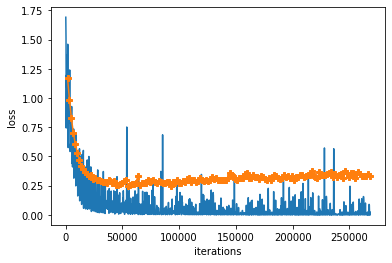

train set eval
epoch:  156
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCC

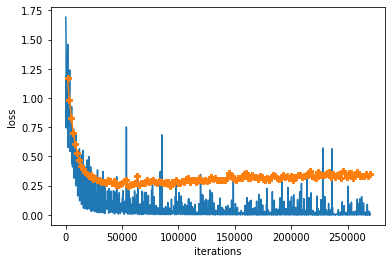

train set eval
epoch:  157
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=

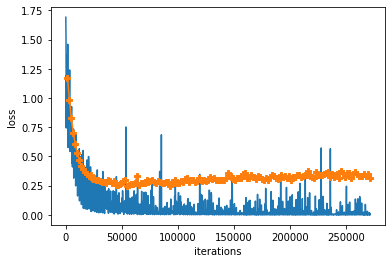

train set eval
epoch:  158
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc

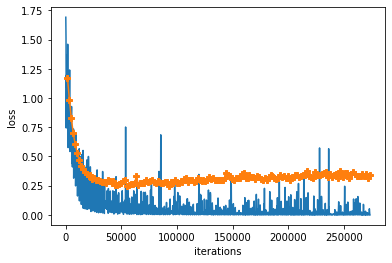

train set eval
epoch:  159
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)

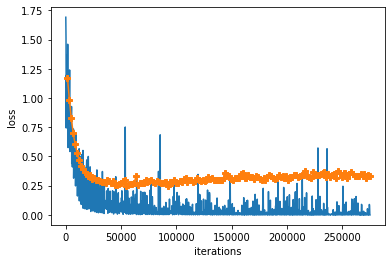

train set eval
epoch:  160
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: CCCCCCC6O<EOS>
real: CCCCCCC6O
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCOC4<EOS>
real: CCOC4
pred: CCOC4<EOS>
real: CCOC4
pred: CCCCCC5=O<EOS>
real: CCCCCC5=O
pred: CCOC4<EOS>
real: CCOC4
pred: C=CC)CCC=O)CC)OC3C7<EOS>
real: C=CC)CCC=O)CC)OC3C7
pred: CCOC4<EOS>
real: CCOC4
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: O=CO)CO)cccccc6<EOS>
real: O=CO)CO)cccccc6
pred: CCCCCC5=O<EOS>
real: CCCCCC5=

In [0]:
epochs = 160
X_train1, X_test1,X_train2,X_test2,X_train3,X_test3,X_train4,X_test4,y_train,y_test = train_test_split(x,x2,x3,x4,y,test_size=0.1,random_state=42,shuffle=True) # 
l_r = 0.00003
decoder = DecoderRNN(EMB,HID,VOC,LAY).cuda()
encoder1 = SetTransformer(2,1,int(HID/4)).cuda()
encoder2 = SetTransformer(1,1,int(HID/4)).cuda()
encoder3 = SetTransformer(1,1,int(HID/4)).cuda()
encoder4 = SetTransformer(1,1,int(HID/4)).cuda()
	
encoder_optimizer1 = optim.RMSprop(encoder1.parameters(),lr = l_r)
encoder_optimizer2 = optim.RMSprop(encoder2.parameters(),lr = l_r) 
encoder_optimizer3 = optim.RMSprop(encoder3.parameters(),lr = l_r)
encoder_optimizer4 = optim.RMSprop(encoder4.parameters(),lr = l_r)
decoder_optimizer = optim.RMSprop(decoder.parameters(),lr = l_r,momentum=0.2)
px = [] 
ppx = [] 
py=[]
ppy=[]
j = 0# iterations
jj = 0# iterations

x_tpair = [X_train1, X_train2,X_train3,X_train4,y_train]
val_pairs = [X_test1,X_test2,X_test3,X_test4,y_test]
b_size = len(X_train1)
for i in range(epochs):
	p = 0 # for plotting
	for b in range(b_size):   # batch
		j += 1 
		p += 1
		decoder_optimizer.zero_grad()
		encoder_optimizer1.zero_grad()
		encoder_optimizer2.zero_grad()
		encoder_optimizer3.zero_grad()
		encoder_optimizer4.zero_grad()
		loss = 0
		smis = y_train[b]
		X_train11 = X_train1[b].unsqueeze(dim=0)
		X_train22 = X_train2[b].unsqueeze(dim=-1)
		X_train33 = X_train3[b].unsqueeze(dim=-1)
		X_train44 = X_train4[b].unsqueeze(dim=-1)
		pretarget = tensor_from_smiles(smis)
		hidden1=encoder1(X_train11) # inithidden , features from encoder output
		temp = torch.randn(LAY,1,int(HID/4)).cuda()
		temp[0] = hidden1
		temp[1] = hidden1
		temp[2] = hidden1
		temp[3] = hidden1
		hidden1 = temp
	 


		#cell1 = hidden1
		hidden2=encoder2(X_train22) # inithidden , features from encoder output
		temp2 = torch.randn(LAY,1,int(HID/4)).cuda()
		temp2[0] = hidden2
		temp2[1] = hidden2
		temp2[2] = hidden2
		temp2[3] = hidden2
		hidden2 = temp2
	
		hidden3=encoder3(X_train33) # inithidden , features from encoder output
		temp3 = torch.randn(LAY,1,int(HID/4)).cuda()
		temp3[0] = hidden3
		temp3[1] = hidden3
		temp3[2] = hidden3
		temp3[3] = hidden3
		hidden3 = temp3
	 


		#cell1 = hidden1
		hidden4=encoder4(X_train44) # inithidden , features from encoder output
		temp4 = torch.randn(LAY,1,int(HID/4)).cuda()
		temp4[0] = hidden4
		temp4[1] = hidden4
		temp4[2] = hidden4
		temp4[3] = hidden4
		hidden4 = temp4
	 


		hidden = torch.cat((hidden1,hidden2,hidden3,hidden4),dim=-1) ###DIIIMMMMMMM?????
		cell = hidden
		target = torch.cuda.LongTensor([0])#0: SOS
		for s in range(len(pretarget)):
			output,hidden,cell  = decoder(target,hidden,cell)
			target = pretarget[s].unsqueeze(dim=0)
			loss += criterion(output, target)
		loss.backward()
		encoder_optimizer1.step()
		encoder_optimizer2.step()
		encoder_optimizer3.step()
		encoder_optimizer4.step()
  
		decoder_optimizer.step() 
		if p % 200 == 0: # plot every
			px.append(j)
			py.append(loss.item()/len(pretarget))

	print("validation set evaluation, epoch:",i+1)
	evaluateTodo(encoder1,encoder2,encoder3,encoder4,decoder,val_pairs)
	voss = evaval(encoder1,encoder2,encoder3,encoder4,decoder,val_pairs)
	print("val",i+1,j,voss)
	ppx.append(j)
	ppy.append(voss)
	plt.plot(px,py)
	plt.plot(ppx,ppy,marker='P')
	plt.xlabel('iterations')
	plt.ylabel('loss')
	plt.show()
	print("train set eval")
	print('epoch: ',i+1)
	evaluateRandomly(encoder1,encoder2,encoder3,encoder4,decoder,x_tpair,n=50)


